In [2]:
from utils import *
import shap


# read data
file_name = "Estimation Data - Full Model - Monopoly - Whole Week.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# keep advertiser ranks 1, 2
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 3)]
(X, Y, T) = define_xyt(data)
# make T binary (only 0, 1)
T = T.apply(lambda x: 0 if x == 1 else 1)

In [2]:
cf = CausalForestDML(
                        model_y=RandomForestRegressor(max_depth=10, min_samples_split=5000),
                        model_t=PropensityModel(max_depth=15, min_samples_split=3000),
                        discrete_treatment='True',
                        criterion='het',
                        n_jobs=n_jobs,
                        n_estimators=500,
                        min_samples_split=8000,
                        max_depth=15,
                        max_samples=0.01,
                        random_state=42,
                        verbose=0   
    )

# tune the model:
# start_time = time.perf_counter()

# tune_params = cf.tune(
#             Y=Y,
#             T=T,
#             X=X,
#             params=cf_param_grid)

# finish_time = time.perf_counter()

# print(f"finished tuning the model in {finish_time - start_time} seconds")

# fit the model using tuned parameters:
start_time = time.perf_counter()

cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)

finish_time = time.perf_counter()
print(f"finished fitting the model in {finish_time - start_time} seconds")


# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3 - Full Data - New.pkl"
joblib.dump(cf, file_name)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished fitting the model in 25614.758257200003 seconds


['..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3 - Full Data - New.pkl']

In [3]:
cf = joblib.load(f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3 - Full Data - New.pkl")

In [5]:
summary_table = cf.summary(decimals=6)
latex_summary = summary_table.as_latex()
with open('..\\results\\Full Model\\Monopoly\\cf 1,3 summary.tex', 'w') as f:
    f.write(latex_summary)
summary_table

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
                 Uncertainty of Mean Point Estimate                
===================================================================
mean_point stderr_mean  zstat   pvalue  ci_mean_lower ci_mean_upper
-------------------------------------------------------------------
 -0.000687    0.000339 -2.0287 0.042489     -0.001351      -2.3e-05
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
   0.0004       -0.001827        -1.8e-05
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.001         -0.002            0.0
           Doubly Robust ATE on Training Data Results          
===============================================================
    point_estimate  stderr   zstat    pvalue  ci_lower ci_upper
---------------------------------------------------------------
ATE      -0.000748 2.5e-05 -30.215573    0.0 -0.000797  -0.0007
        Doubly Robust ATT(T=0) on Training Data Results         
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATT      -0.000615 3.4e-05 -18.296787    0.0 -0.000681 -0.000549
        Doubly Robust ATT(T=1) on Training Data Results         
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATT       -0.00091 3.7e-05 -24.831536    0.0 -0.000982 -0.000838
----------------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

# Shapley Values

In [48]:
X.rename(columns={
    'impression_repeat': 'Repeats',
     'impression_repeat_base_ad': 'Base Ad Repeats',
     'previous_clicks': 'Previous Clicks',
     'previous_clicks_base_ad': 'Base Ad Previous Clicks',
     'previous_clicks_all_ads': 'All Ads Previous Clicks',
     'total_visits': "Total Pages Visited",
     'visit_s1' : 'Art',
     'visit_s2' : 'Childcare',
     'visit_s3' : 'Education',
     'visit_s4' : 'Entertainment',
     'visit_s5' : 'Finance',
     'visit_s6' : 'Heath',
     'visit_s7' : 'Lifestyle',
     'visit_s8' : 'Movies',
     'visit_s9' : 'Music',
     'visit_s10' : 'Other',
     'visit_s11' : 'Politics',
     'visit_s12' : 'Sport',
     'visit_s13' : 'Technology',
     'sub_1' : 'Art FE',
     'sub_2' : 'Childcare FE',
     'sub_3' : 'Education FE',
     'sub_4' : 'Entertainment FE',
     'sub_5' : 'Finance FE',
     'sub_6' : 'Heath FE',
     'sub_7' : 'Lifestyle FE',
     'sub_8' : 'Movies FE',
     'sub_9' : 'Music FE',
     'sub_10' : 'Other FE',
     'sub_11' : 'Politics FE',
     'sub_12' : 'Sport FE',
     'sub_13' : "Technology FE",
     'publisher_rank_sub': 'Website Rank within Subject',
     'day': "Day",
     'hour': "Hour of the Day",
     'mobile': "Mobile",
    'ads_on_page': 'Ads on the Page'
       
}, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
shap_values = cf.shap_values(X[X.index % 3000 == 0])

 99%|===================| 3668/3707 [01:36<00:01]        

In [1]:
ad_3_mean_ctr = data.loc[(data['advertiser_rank'] == 3), 'is_clicked'].mean()
shap.plots.beeswarm(shap_values['is_clicked']['advertiser_rank_1'] / ad_3_mean_ctr * 100)
plt.savefig(f"..\\results\\Full Model\\Figures\\Shapley Values bw Ad 1, 3.jpg", dpi=900)

NameError: name 'data' is not defined

# Treatment Effect Heterogeneity

In [4]:
m = cf.model_y.fit(X[X.index % 20 == 0], Y[X.index % 20 == 0])
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 3 - Full Data.pkl"
joblib.dump(m, file_name)
e =  cf.model_t.fit(X[X.index % 20 == 0], T[X.index % 20 == 0])
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 3 - Full Data.pkl"
joblib.dump(e, file_name)

KeyboardInterrupt: 

In [5]:
# Load the models above
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 3 - Full Data.pkl"
m = joblib.load(file_name)
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 3 - Full Data.pkl"
e = joblib.load(file_name)

In [6]:
te_ci = cf.const_marginal_effect_interval(X[X.index % 10 == 0])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2
d = {'te': te, 'te_h': te_h, 'te_l': te_l}
te_dataset=pd.DataFrame(data=d)
te_dataset = te_dataset.sort_values('te')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100

In [11]:
percentiles = np.array([1, 20, 40, 60, 80, 99.99])
indices = np.floor(percentiles / 100 * len(te_dataset))
te_sub = te_dataset.loc[indices, ['pct', 'te', 'te_h', 'te_l']]

([<matplotlib.axis.XTick at 0x27c75280700>,
 [Text(1, 0, '1'),
  Text(20, 0, '20'),
  Text(40, 0, '40'),
  Text(60, 0, '60'),
  Text(80, 0, '80'),
  Text(99, 0, '99')])

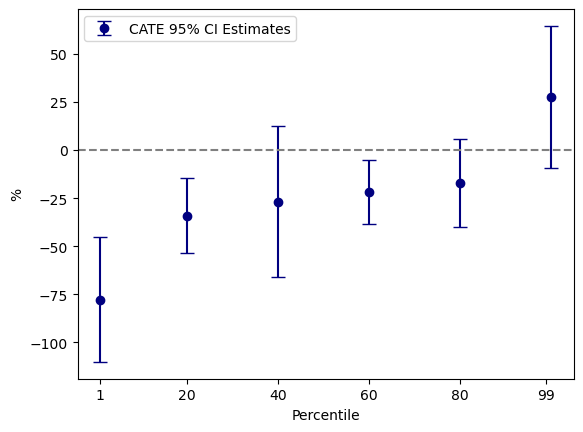

In [12]:
ad1_ctr = data.loc[data['advertiser_rank']== 1, 'is_clicked'].mean()
plt.errorbar(te_sub.pct, te_sub.te / ad1_ctr * 100, yerr=(te_sub.te_h-te_sub.te_l) / 2/ ad1_ctr * 100, fmt="o", capsize=5, color='navy')
plt.xlabel('Percentile')
plt.ylabel('%')
# plt.title("Treatment Effect Heterogeneity")
plt.legend(['CATE 95% CI Estimates'], )
plt.axhline(y=0, color='gray', linestyle='--')
plt.xticks([1, 20, 40, 60, 80, 99])
